In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize
from scipy.interpolate import griddata, interp1d
import pandas as pd

In [2]:
np.random.seed = 48

%matplotlib inline

In [3]:
class pointCloud:
    def __init__(self, xx, yy, zz):
        self.points = np.array([xx.flatten(),yy.flatten(),zz.flatten()])
    

    
    def plot(self, fig = None, ax=None):
        def set_aspect_equal_3d(ax):
            """Fix equal aspect bug for 3D plots.
                Courtesy of user dalum,
                https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
            """

            xlim = ax.get_xlim3d()
            ylim = ax.get_ylim3d()
            zlim = ax.get_zlim3d()

            from numpy import mean
            xmean = mean(xlim)
            ymean = mean(ylim)
            zmean = mean(zlim)

            plot_radius = max([abs(lim - mean_)
                               for lims, mean_ in ((xlim, xmean),
                                                   (ylim, ymean),
                                                   (zlim, zmean))
                               for lim in lims])

            ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
            ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
            ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])
        
        if not fig:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.points[0], self.points[1], self.points[2], alpha = 0.4, marker='.')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        #ax.set_aspect('equal')
        set_aspect_equal_3d(ax)
        
        return fig, ax
        
    def rotate(self, axis, angleDegrees):
        '''
        Takes two arguments; the axis of rotation and the angle of rotation. The angle is in radians.
        
        Please remember that it rotates around the coordinate point (0,0,0). It's a bit tricky.
        '''
        r = None
        
        angle = angleDegrees/180*np.pi
        
        if axis == "X": r = Rotation.from_rotvec(angle * np.array([1, 0, 0]))
        if axis == "Y": r = Rotation.from_rotvec(angle * np.array([0, 1, 0]))
        if axis == "Z": r = Rotation.from_rotvec(angle * np.array([0, 0, 1]))
        
        if r:
            self.points = r.apply(self.points.T).T
        
        return self
    
    def rotateEuler(self, alpha, beta, gamma):
        r = Rotation.from_euler('xyz', [alpha, beta, gamma], degrees = True)
        self.points = r.apply(self.points.T).T
        
        return self
        
    def displace(self, axis, distance):
        if axis == "X":   self.points[0] += distance
        elif axis == "Y": self.points[1] += distance
        elif axis == "Z": self.points[2] += distance
        else:             pass
        
        return self
    
    def addNoise(self, axis, std):
        if axis == "X":   self.points[0] += np.random.randn(len(self.points[0]))*std
        elif axis == "Y": self.points[1] += np.random.randn(len(self.points[1]))*std
        elif axis == "Z": self.points[2] += np.random.randn(len(self.points[2]))*std
        else:             pass
        
        return self
    
    def copy(self):
        return pointCloud(self.points[0].copy(), self.points[1].copy(), self.points[2].copy())
    
    def copyCropped(self, N):
        return pointCloud(self.points[0][::N].copy(),
                          self.points[1][::N].copy(),
                          self.points[2][::N].copy())

## Define cost functions

In [4]:
def RMSdiff(a, b):    
    return np.sqrt(np.mean((a - b)**2) )

def MSdiff(a, b):    #Shows no good traits. The solutions usually does not converge any better.
    return np.mean((a - b)**2)

def RMS3Diff(a, b):
    '''
    The function takes two 3vectors, and calculate the pointwise RMS distance between them.    
    '''
    
    dists = np.sqrt((a.points[0] - b.points[0])**2 
                    + (a.points[1] - b.points[1])**2 
                    + (a.points[2] - b.points[2])**2)
    
    return np.sqrt(np.mean(dists**2))

## Define target function for fit

In [5]:
def oap(x, y, EFL):
    r = np.sqrt(x**2 + y**2)
    return r**2 / (2*EFL)

## Define objective function

In [6]:
def objectiveEuler(params, *args):
    alpha, beta, gamma, dispZ = params
    sample = args[0]
    plotBool = args[1]
    printRA = args[2]
    returnData = args[3]
    sampleDisplaced = pointCloud(sample.points[0], 
                                 sample.points[1], 
                                 sample.points[2])
    
    #Apply corrections
    sampleDisplaced.rotateEuler(alpha, beta, gamma)
    sampleDisplaced.displace('Z', dispZ)
    
    if plotBool:
        fig, ax = sampleDisplaced.plot()
        theory.plot(fig=fig, ax=ax)
        
    if printRA:
        peak = np.max(sampleDisplaced.points[2])
        valley = np.min(sampleDisplaced.points[2])
        Ra = np.mean(np.abs(sampleDisplaced.points[2]))
        Rt = peak-valley
        Rq = np.sqrt(np.mean(sampleDisplaced.points[2]**2))
        
        print('Rp = {:1.4f} um'.format(peak*1000))
        print('Rv = {:1.4f} um'.format(valley*1000))
        print('Rt = {:1.4f} um'.format(Rt*1000))
        print('Ra = {:1.4f} um'.format(Ra*1000))
        print('Rq = {:1.4f} um'.format(Rq*1000))
        
    if returnData:
        return sampleDisplaced
        

    return np.sqrt(np.mean(sampleDisplaced.points[2]**2))



In [7]:
def objective2Euler(params, *args):
    alpha1, beta1, gamma1, dispX, dispZ, dispY, alpha2, beta2, gamma2 = params
    sample = args[0]
    plotBool = args[1]
    printRA = args[2]
    returnData = args[3]
    sampleDisplaced = pointCloud(sample.points[0], 
                                 sample.points[1], 
                                 sample.points[2])
    
    #Apply corrections
    sampleDisplaced.rotateEuler(alpha1, beta1, gamma1)
    sampleDisplaced.displace('X', dispX)
    sampleDisplaced.displace('Z', dispZ)
    sampleDisplaced.displace('Y', dispY)
    sampleDisplaced.rotateEuler(alpha2, beta2, gamma2)

    theory = pointCloud(sampleDisplaced.points[0],
                        sampleDisplaced.points[1],
                        oap(sampleDisplaced.points[0], sampleDisplaced.points[1], 150))
    
    if plotBool:
        fig, ax = sampleDisplaced.plot()
        theory.plot(fig=fig, ax=ax)
    
    if printRA:
        peak = np.max(sampleDisplaced.points[2])
        valley = np.min(sampleDisplaced.points[2])
        Ra = np.mean(np.abs(sampleDisplaced.points[2]))
        Rt = peak-valley
        Rq = np.sqrt(np.mean(sampleDisplaced.points[2]**2))
        
        print('Rp = {:1.4f} um'.format(peak*1000))
        print('Rv = {:1.4f} um'.format(valley*1000))
        print('Rt = {:1.4f} um'.format(Rt*1000))
        print('Ra = {:1.4f} um'.format(Ra*1000))
        print('Rq = {:1.4f} um'.format(Rq*1000))
        
    if returnData:
        return sampleDisplaced

    #return RMSdiff(sampleDisplaced.points[2], theory.points[2])
    return RMS3Diff(sampleDisplaced, theory)#+np.sqrt(np.abs(np.mean(sampleDisplaced.points[0])))



In [8]:
def objectiveSimple(params, *args):
    dispX, dispZ, dispY, alpha2, beta2, gamma2 = params
    sample = args[0]
    plotBool = args[1]
    printRA = args[2]
    returnData = args[3]
    sampleDisplaced = pointCloud(sample.points[0], 
                                 sample.points[1], 
                                 sample.points[2])
    
    #Apply corrections
    #sampleDisplaced.rotateEuler(alpha1, beta1, gamma1)
    sampleDisplaced.displace('X', dispX)
    sampleDisplaced.displace('Z', dispZ)
    sampleDisplaced.displace('Y', dispY)
    sampleDisplaced.rotateEuler(alpha2, beta2, gamma2)

    theory = pointCloud(sampleDisplaced.points[0],
                        sampleDisplaced.points[1],
                        oap(sampleDisplaced.points[0], sampleDisplaced.points[1], 150))
    
    if plotBool:
        fig, ax = sampleDisplaced.plot()
        theory.plot(fig=fig, ax=ax)
    
    if printRA:
        peak = np.max(sampleDisplaced.points[2])
        valley = np.min(sampleDisplaced.points[2])
        Ra = np.mean(np.abs(sampleDisplaced.points[2]))
        Rt = peak-valley
        Rq = np.sqrt(np.mean(sampleDisplaced.points[2]**2))
        
        print('Rp = {:1.4f} um'.format(peak*1000))
        print('Rv = {:1.4f} um'.format(valley*1000))
        print('Rt = {:1.4f} um'.format(Rt*1000))
        print('Ra = {:1.4f} um'.format(Ra*1000))
        print('Rq = {:1.4f} um'.format(Rq*1000))
        
    if returnData:
        return sampleDisplaced

    #return RMSdiff(sampleDisplaced.points[2], theory.points[2])
    return RMS3Diff(sampleDisplaced, theory)#+np.sqrt(np.abs(np.mean(sampleDisplaced.points[0])))/10



In [9]:
def samplePolarCoords(dx, dy, r, N):
    #I sample in polar coordinates around (dx, dy), in radius r. NxN points are returned.
    angs = np.random.rand(N**2)*2*np.pi
    rs = np.random.rand(N**2)*r
    xs = (dx + np.cos(angs)*rs).reshape(N,N)
    ys = (dy + np.sin(angs)*rs).reshape(N,N)
    
    return xs, ys

## Read data and subtract z error from robot trajectory

In [10]:
# Read scan direction error
xx, scanLineError = np.load('./20190815_ErrorAlongScanLine.npy')

#set up interpolator:
SLEinterpolator = interp1d(xx, scanLineError, bounds_error=False, fill_value=0.0)

In [11]:
df = pd.read_csv('/Users/cbs/Documents/3D_mirrors/Scanninger/Poleret_emne_clean_tap.xyz', header = None, names=['x','y','z','NA0','NA1','NA2'], delim_whitespace=True)
data = pointCloud(df.x.to_numpy(), df.y.to_numpy(), df.z.to_numpy() - SLEinterpolator(df.y.to_numpy())) #Tried with interpolator on x axis - was not impressive
#data = pointCloud(df.x.to_numpy(), df.y.to_numpy(), df.z.to_numpy())
del df

## Aligning manually to provide robust initial guess

In [12]:
cp = data.copyCropped(N=1217).rotate('X', 180).rotate('Z', 180).displace('Z', 120).rotate('X', 35).displace('Y', 25).displace('Z', -20)

xT, yT = samplePolarCoords(0, 100, 50, 100)
theory = pointCloud(xT, yT, oap(xT, yT, 150))

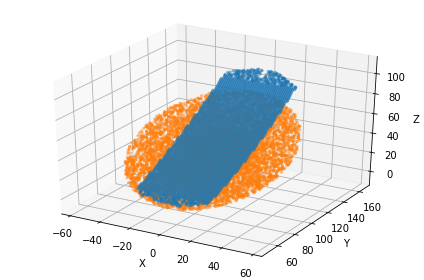

In [13]:
fig, ax = cp.plot()
theory.plot(fig,ax)
plt.tight_layout()

## Do initial fit

In [14]:
x0s = [0, 0, 0, 0, 0, 0]
args = (cp, False, False, False)
opts = {'disp':True, 'maxiter':5000}
result = minimize(objectiveSimple, x0=x0s, args=args, options=opts, method='Nelder-Mead', tol=1e-8)

Optimization terminated successfully.
         Current function value: 0.051862
         Iterations: 1860
         Function evaluations: 2919


Rp = 134984.5680 um
Rv = 36213.5156 um
Rt = 98771.0523 um
Ra = 82749.0244 um
Rq = 87150.9379 um


0.05186223528715884

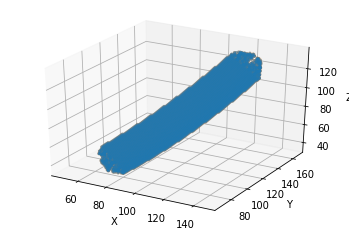

In [15]:
objectiveSimple(result.x, cp, True, True, False)

In [16]:
result.x

array([ -2.52632177,   2.63588571,  59.23583356,  11.44614314,
         1.34807879, -40.24400093])

## Do fit of entire dataset

In [18]:
total = data.copy().rotate('X', 180).rotate('Z', 180).displace('Z', 120).rotate('X', 35).displace('Y', 25).displace('Z', -20)

In [19]:
args = (total, False, False, False)
opts = {'disp':True, 'maxiter':5000}
result = minimize(objectiveSimple, x0=result.x, args=args, options=opts, method='Nelder-Mead', tol=1e-12)

Optimization terminated successfully.
         Current function value: 0.051432
         Iterations: 430
         Function evaluations: 828


Rp = 134976.9364 um
Rv = 36206.4300 um
Rt = 98770.5064 um
Ra = 82741.7414 um
Rq = 87143.8202 um


0.051865686231311256

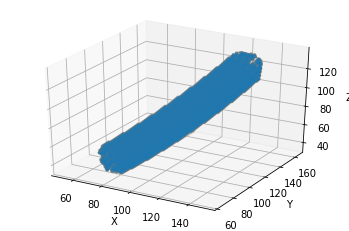

In [20]:
objectiveSimple(result.x, cp, True, True, False)

In [21]:
result.x

array([ -2.56364807,   2.63278125,  59.22627963,  11.44489006,
         1.35693578, -41.96732472])

## Rotate back to horizontal to image the scanned z-error

In [22]:
# Return pointCloud object
fit = objectiveSimple(result.x, total, False, False, True)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x131cfc34e0>)

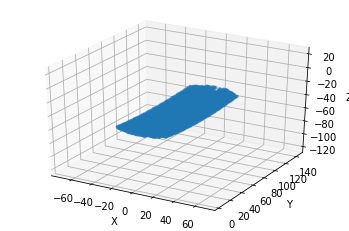

In [23]:
# Find the expected rough manual rotation to horizontal.
sectionFit = fit.copyCropped(N=1423).rotate('Z',43).rotate('X', -45).displace('X', 3).displace('Y',-95)
sectionFit.plot()

In [24]:
theory = pointCloud(fit.points[0], fit.points[1], oap(fit.points[0], fit.points[1], EFL=150))

In [25]:
fitRotated = fit.copy().rotate('Z',43).rotate('X', -45).displace('X', 3).displace('Y',-95)
theoryRotated = theory.copy().rotate('Z',43).rotate('X', -45).displace('X', 3).displace('Y',-95)

zDiff = fitRotated.points[2]-theoryRotated.points[2]

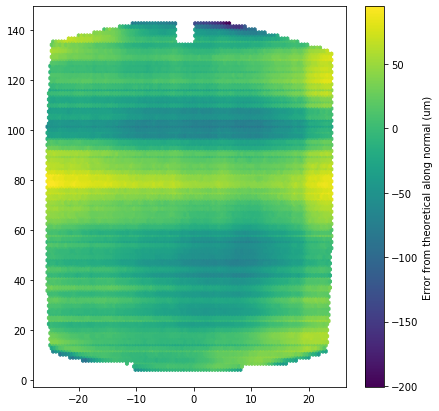

In [30]:
nn = 13
plt.figure(figsize=(7,7))
plt.hexbin(fitRotated.points[0][::nn], fitRotated.points[1][::nn], zDiff[::nn]*1000)
plt.colorbar(label='Error from theoretical along normal (um)')

### Sample onto structured grid

In [27]:
nx = 1000
ny = 2000
nn = 27


xs = np.linspace(fitRotated.points[0].min(), fitRotated.points[0].max(), nx)
ys = np.linspace(fitRotated.points[1].min(), fitRotated.points[1].max(), ny)
xx, yy = np.meshgrid(xs,ys)


points = np.array(([fitRotated.points[0][::nn], fitRotated.points[1][::nn]])).T

zzAlongY = griddata( points,
               zDiff[::nn],
               xi = (xx,yy),
               method = 'linear')

Text(0, 0.5, 'Transverse distance (mm)')

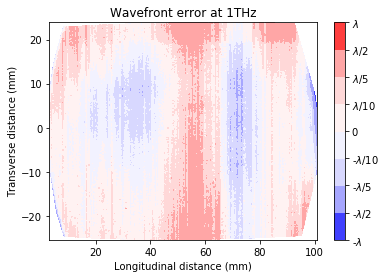

In [28]:
fig, ax = plt.subplots()

wl = 300
tickvalues = [-wl, -wl/2, -wl/5, -wl/10, 0, wl/10, wl/5, wl/2, wl]
cax = ax.contourf(yy/np.sqrt(2), xx, zzAlongY*1000, levels=tickvalues, cmap = 'bwr')

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=tickvalues)
cbar.ax.set_yticklabels(['-$\lambda $', '-$\lambda $/2', '-$\lambda $/5', '-$\lambda $/10', '0', '$\lambda $/10', '$\lambda $/5', '$\lambda $/2', '$\lambda $'])  # vertically oriented colorbar


plt.title('Wavefront error at 1THz')

plt.xlabel('Longitudinal distance (mm)')
plt.ylabel('Transverse distance (mm)')

# It actually works. Who'da'thunk. 